In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [3]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'gmm_exp' in c['name'] 
        and c['config']['experiment']['latent_dim'] == 64
        and c['config']['experiment']['hidden_dim'] == 128
        and c['config']['dataset']['prior_mu'] == [0, 5]
        and hasattr(c['config']['encoder'], 'layers')
        and c['config']['encoder']['layers'] == 4 
]   
# cfgs = [cfgs[1]]


import hydra
# load + prep dataset
def prepare_dataset_and_mixer(cfg, set_size=None, n_sets=None, n_mixed_sets=None):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    if set_size is not None:
        cfg['dataset']['set_size'] = set_size
    if n_sets is not None:
        cfg['dataset']['n_sets'] = n_sets
    if n_mixed_sets is not None:
        cfg['mixer']['n_mixed_sets'] = n_mixed_sets
    dataset = hydra.utils.instantiate(cfg['dataset'])
    mixer = hydra.utils.instantiate(cfg['mixer'])
    return dataset, mixer


# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

enc, gen = load_model(cfgs[0]['config'], cfgs[0]['dir'], device)


In [4]:
cfgs

[{'name': 'gmm_exp_7887ebf20a7a0786cb8a59b21a79c236',
  'dir': '../outputs/gmm_exp_7887ebf20a7a0786cb8a59b21a79c236',
  'config': {'dataset': {'_target_': 'datasets.distribution_datasets.MultivariateNormalDistributionDataset', 'n_sets': 50000, 'set_size': '${experiment.set_size}', 'data_shape': [2], 'seed': '${seed}', 'prior_mu': [0, 5], 'prior_cov_df': 10, 'prior_cov_scale': 1}, 'encoder': {'_target_': 'encoder.encoders.DistributionEncoderResNet', 'in_dim': '${dataset.data_shape[0]}', 'latent_dim': '${experiment.latent_dim}', 'hidden_dim': '${experiment.hidden_dim}', 'set_size': '${experiment.set_size}', 'layers': 4, 'fc_layers': 2}, 'model': {'_target_': 'layers.MLP', 'in_dims': [2, 64, 1], 'hidden_dim': 128, 'out_dim': 2, 'layers': 4}, 'generator': {'_target_': 'generator.ddpm.DDPM', 'model': '${model}', 'betas': [0.0001, 0.02], 'n_T': 400, 'drop_prob': 0.1, 'noise_shape': '${dataset.data_shape}'}, 'optimizer': {'_target_': 'torch.optim.Adam', '_partial_': True, 'lr': '${experiment.

In [5]:
from torch.utils.data import DataLoader
ds, mx = prepare_dataset_and_mixer(cfgs[0]['config'], set_size=1_000_000, n_sets=1000, n_mixed_sets=16)
dl = DataLoader(ds, batch_size=16, shuffle=True, collate_fn=mx.collate_fn)

In [6]:
import numpy as np
import torch
import gc


from ot.gmm import gmm_ot_loss

latent_dists = []
ot_dists = []

gc.collect()
torch.cuda.empty_cache()

for i, (batch_s, batch_t) in enumerate(zip(iter(dl), iter(dl))):
    print(f'{i}/{len(dl)}')
    samples_s = batch_s['samples'].to(device)
    means_s = batch_s['mean'].to(device)
    covs_s = batch_s['cov'].to(device)
    samples_t = batch_t['samples'].to(device)
    means_t = batch_t['mean'].to(device)
    covs_t = batch_t['cov'].to(device)

    with torch.no_grad():
        enc_s = enc(samples_s).detach().cpu().numpy()
        enc_t = enc(samples_t).detach().cpu().numpy()


    latent_dists.append(np.linalg.norm(enc_s - enc_t, axis=1))
    # this is simply impossible to vectorize, vmap fails because they compute the sinkhorn with numpy primitives
    ot_dists += [
        gmm_ot_loss(means_si, means_ti, covs_si, covs_ti).detach().cpu().numpy() 
        for means_si, means_ti, covs_si, covs_ti in zip(means_s, means_t, covs_s, covs_t)
    ]

    # clear cuda cache
    gc.collect()
    torch.cuda.empty_cache()


0/63
1/63
2/63
3/63
4/63
5/63
6/63
7/63
8/63
9/63
10/63
11/63
12/63
13/63
14/63
15/63
16/63
17/63
18/63
19/63
20/63
21/63
22/63
23/63
24/63
25/63
26/63
27/63
28/63
29/63
30/63
31/63
32/63
33/63
34/63
35/63
36/63
37/63
38/63
39/63
40/63
41/63
42/63
43/63
44/63
45/63
46/63
47/63
48/63
49/63
50/63
51/63
52/63
53/63
54/63
55/63
56/63
57/63
58/63
59/63
60/63
61/63
62/63


In [7]:
latent_dists = np.concatenate(latent_dists)
ot_dists = np.sqrt(np.array(ot_dists))

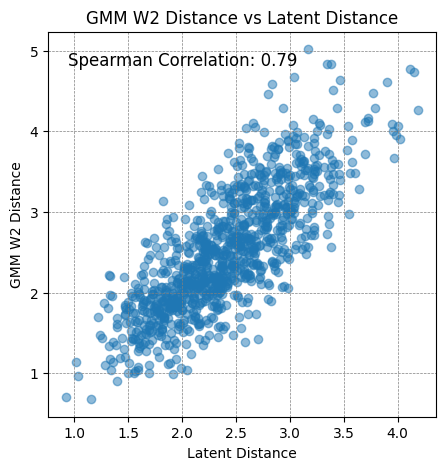

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# make this beautiful
plt.figure(figsize=(5, 5))
plt.scatter(latent_dists, ot_dists, alpha=0.5)
plt.xlabel('Latent Distance')
plt.ylabel('GMM W2 Distance')
plt.title('GMM W2 Distance vs Latent Distance')
# add grey backgroud grid
plt.grid(color='grey', linestyle='--', linewidth=0.5)
# add spearman correlation
plt.text(0.05, 0.95, f'Spearman Correlation: {spearmanr(latent_dists, ot_dists)[0]:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.show()
